In [35]:
import seaborn as sns
from seaborn import FacetGrid
import pandas as pd
import matplotlib.pyplot as plt
import os
import pytz

df = None

# Get list of files in directory
files = os.listdir('data/images/cropped')

def convert_to_dataframe(files):
    # Create empty dict
    file_dict = {}

    # Loop through the files
    for file in files:
        # Split the filenames
        parts = file.split('_')
        if parts[0] == 'image':
            video_id = parts[1]
            timestamp = parts[2] + "_" + parts[3]
            # Create a key for the dictionary using the video_id and timestamp
            key = f"{video_id}_{timestamp}"
            # If the key doesn't exist in the dictionary, create a new list for it
            if key not in file_dict:
                file_dict[key] = []
            # Append the file path to the list of file paths for this key
            file_dict[key].append(os.path.join('data/images/cropped', file))

    # Convert to Pandas dataframe
    rows = []
    for key, value in file_dict.items():
        video_id = key.split("_")[0]
        timestamp = key.split("_")[1] + "_" + key.split("_")[2]
        count = len(value)
        rows.append((video_id, timestamp, count))

    df = pd.DataFrame(rows, columns=["video_id", "timestamp", "count"])
    df['timestamp']=pd.to_datetime(df['timestamp'],format='%Y-%m-%d_%H-%M-%S')
    
    # Convert to timezone where videos were recorded
    namibia_tz = pytz.timezone('Africa/Windhoek')
    df['timestamp'] = df['timestamp'].dt.tz_localize('UTC').dt.tz_convert(namibia_tz)
    
    mask = df['timestamp'] < "2022-12-13 05:00:00"
    df = df[mask]
    
    return df
    
df = convert_to_dataframe(files)

def plot_timeseries(df):
    # Group the data by video_id and timestamp, and calculate the count for each group
    df_plot = df.groupby(['video_id', 'timestamp'])['count'].sum().reset_index()

    # Use seaborn to create a timeseries plot with timestamp in the x-axis and count in the y-axis
    sns.set_style("darkgrid")
    sns.lineplot(x="timestamp", y="count", hue="video_id", data=df_plot)
    
    plt.xticks(rotation=45)



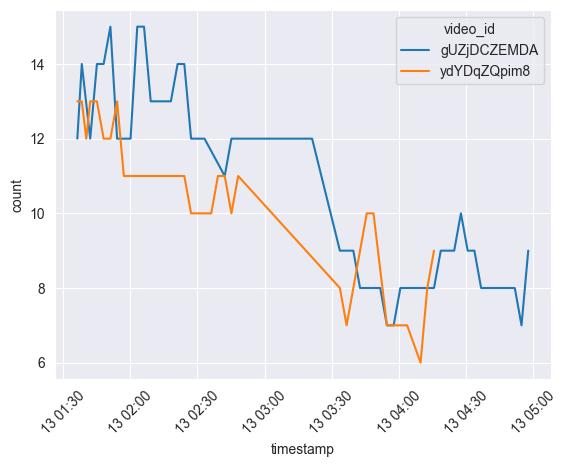

In [36]:
plot_timeseries(df)

# Timeseries

This timeseries analysis shows a similar trend in activity between the two sites. Activity, as inferred by number of individuals, decreases from 1:30pm to 5:00pm across sites. This information could inform biologist seeking to collect appropriate field data, conservations on the need to adjust monitoring counts depending on the time of day, and even tour operators seeking to maximize the exposure of clients to wildlife.

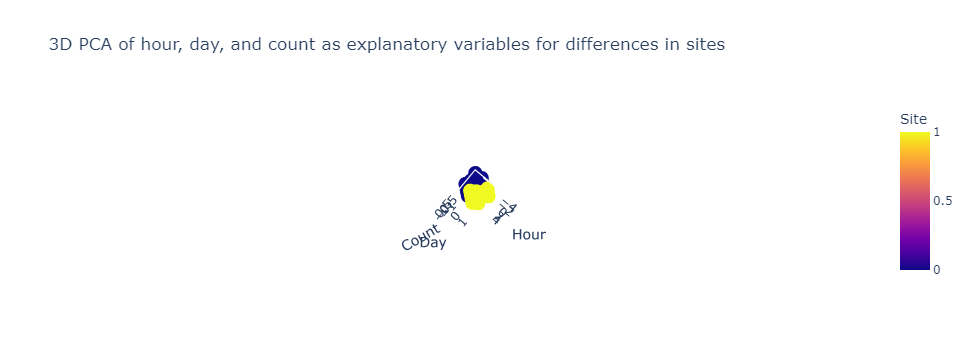

In [42]:
import numpy
import pandas as pd
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

# Extract the time and day from the timestamp
df['hour'] = df['timestamp'].apply(lambda x: x.hour)
df['day'] = df['timestamp'].apply(lambda x: x.day)

# PCA can only accept numeric values, so convert species names to unique numbers
encoder = LabelEncoder()
encoder.fit(df['video_id'])
species_encoded = encoder.transform(df['video_id'])
df['id_encoded'] = species_encoded

# Select the columns for the PCA analysis
X = df[['hour', 'day', 'count', 'id_encoded']]
X = X.dropna()

# Initialize the PCA object with 3 components
pca = PCA(n_components=3)

# Fit the PCA model to the data and transform it
components = pca.fit_transform(X)

# Calculate the total explained variance
total_var = pca.explained_variance_ratio_.sum() * 100

# Create a 3D scatter plot using plotly express
fig = px.scatter_3d(
    components, x=0, y=1, z=2, color=X['id_encoded'],
    title=f'3D PCA of hour, day, and count as explanatory variables for differences in sites',
    labels={'0': 'Hour', '1': 'Day', '2': 'Count', 'color': "Site"}
)

# Display the plot
fig.show()


# PCA

An interative 3D PCA can give further insight into the activity patterns of animals at the studied sites. Viewed from above, it is visible that ther is likely a difference in how animals respond to the change of hour on a given day. This initial observation could inspire a study into why these difference exist.

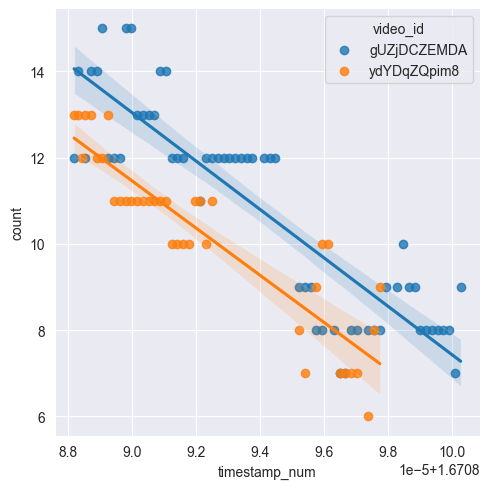

In [62]:
# Import seaborn
import seaborn as sns

# Convert the datetime values to numeric values (e.g., seconds since the epoch)
df['timestamp_num'] = df['timestamp'].apply(lambda x: x.timestamp() / 10**9)

# Create a scatter plot with two groups and add a trendline to each group
sns.lmplot(x='timestamp_num', y='count', data=df, hue='video_id', fit_reg=True, legend=True, facet_kws={'legend_out': False})# Loop over the axes in the FacetGrid object


# Linear regression

In order to quantify the correlation between the count of animals and the time of day, a simple correlation analysis was conducted. The similar slopes in the trends between sites are inline with the trend in the time series. However, the trendlines are offset, which is in agreement with the above view of the PCA plot. Altogether, there is a similar response of animals to the changing times of the day across these two sites, however these responses are not identical even though these sites are geographically similar with overlapping species and common climatic conditions. It would be interesting to study why these similarities/differences may be occuring.

These initial analyses encourage further inquiry, but because of the short sampling period of two days, statstical significance cannot be derived from any of the exploratory analyses detailed here.